In [2]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation

sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.figsize'] = (4,4)


controls2 = ['Dabrafenib', 'Belinostat']

main_dir = '../'

def plot_CDF(data, title='', figsize=(4,4)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)

    # Plot the CDF
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)
    plt.show()


In [3]:
sc_counts = ad.read(f'{main_dir}/input/sc_counts.h5ad')
sc_counts.X = sc_counts.layers['counts']
sc_counts.var_names_make_unique()
sc_counts.obs['positive_ctr'] = sc_counts.obs.sm_name.isin(controls2)

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
# merge T cells
CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}
sc_counts.obs['cell_type'] = sc_counts.obs['cell_type'].map(cell_type_map)

In [5]:
sc_counts.obs['cell_type'].unique()

array(['B cells', 'T cells', 'Myeloid cells', 'NK cells'], dtype=object)

In [6]:
sc_counts.obs['plate_name'] = sc_counts.obs['plate_name'].astype(str).apply(lambda name: name.split('-')[1]).astype('category')
# define specific id for cell type of each well 
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')

# QC + cell type annotation: original

In [7]:
# pbmc_markers = pd.read_csv(f"{main_dir}/output/decoupler_final_labels.csv")

In [8]:
if False:
    # sc.pp.filter_genes(adata, min_cells=100)
    # adata = adata[:,~adata.var.index.str.startswith('MT-')].copy()

    import decoupler as dc
    pbmc_markers = pd.read_csv(f"{main_dir}/output/decoupler_final_labels.csv")

    def run_dc(adata, labels, resolution, meta_name):
        
        adata = adata.copy()
        ## Run ORA:
        dc.run_ora(
        mat=adata,
        net=labels,
        source='cell_type',
        target='genesymbol',
        min_n=3,
        verbose=True
        )
        
        acts = dc.get_acts(adata, obsm_key='ora_estimate')
        # We need to remove inf and set them to the maximum value observed
        acts_v = acts.X.ravel()
        max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
        acts.X[~np.isfinite(acts.X)] = max_e

        # We can scale the obtained activities for better visualizations
        sc.pp.scale(acts)
        
        df = dc.rank_sources_groups(acts, groupby='leiden_'+str(resolution), reference='rest', method='wilcoxon')
        
        n_ctypes = 3
        ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
        
        annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
        adata.obs[str(meta_name)] = [annotation_dict[clust] for clust in adata.obs['leiden_'+str(resolution)]]
        
        return adata

    # adata = run_dc(adata, labels= pbmc_markers, resolution=2.0, meta_name="cell_type")

# QC

In [9]:
import sctk
sctk.calculate_qc(sc_counts)
sc_counts

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


AnnData object with n_obs × n_vars = 301785 × 21265
    obs: 'dose_uM', 'timepoint_hr', 'raw_cell_id', 'hashtag_id', 'well', 'container_format', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'positive_ctr', 'plate_well_cell_type', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'counts'

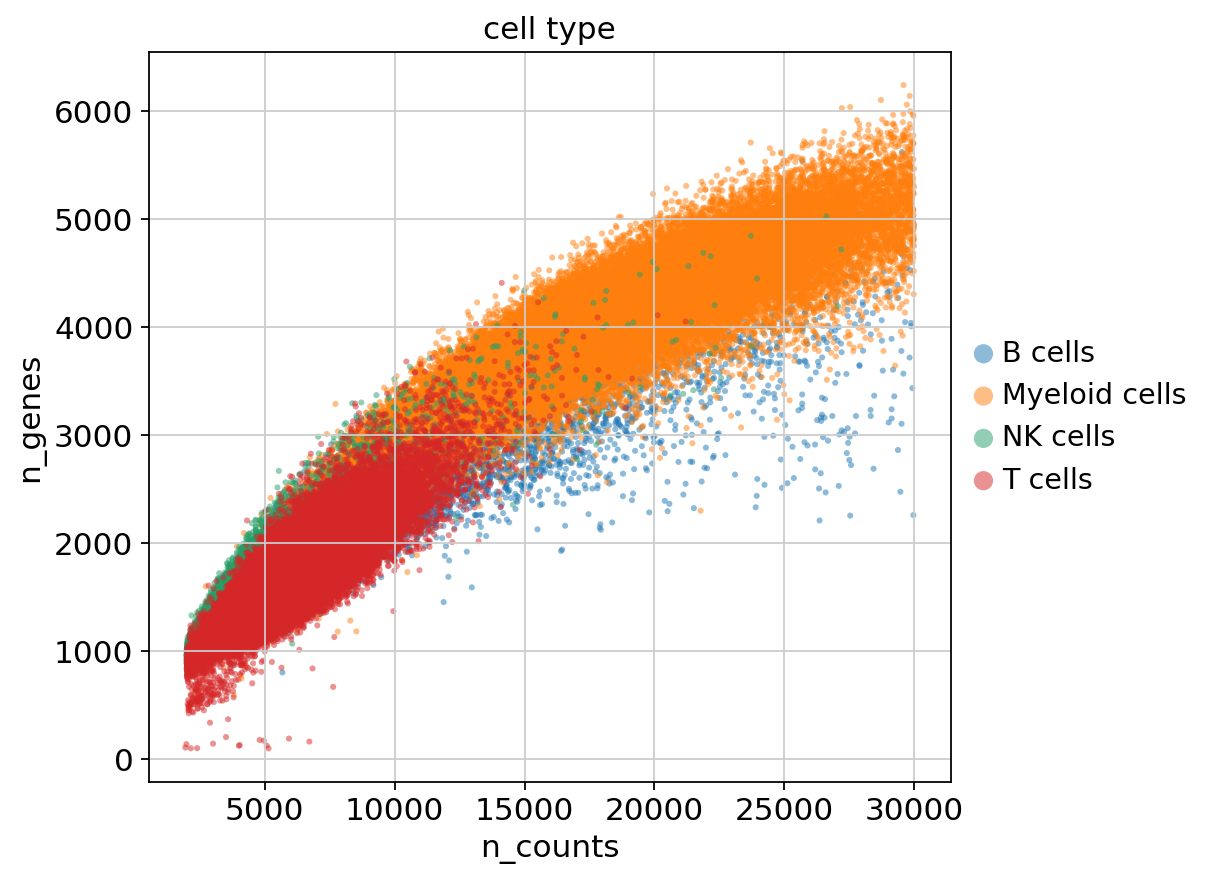

In [10]:
sc.set_figure_params(figsize=(6,6))
p3 = sc.pl.scatter(sc_counts, "n_counts", "n_genes", color="cell_type", size=30, alpha=.5)

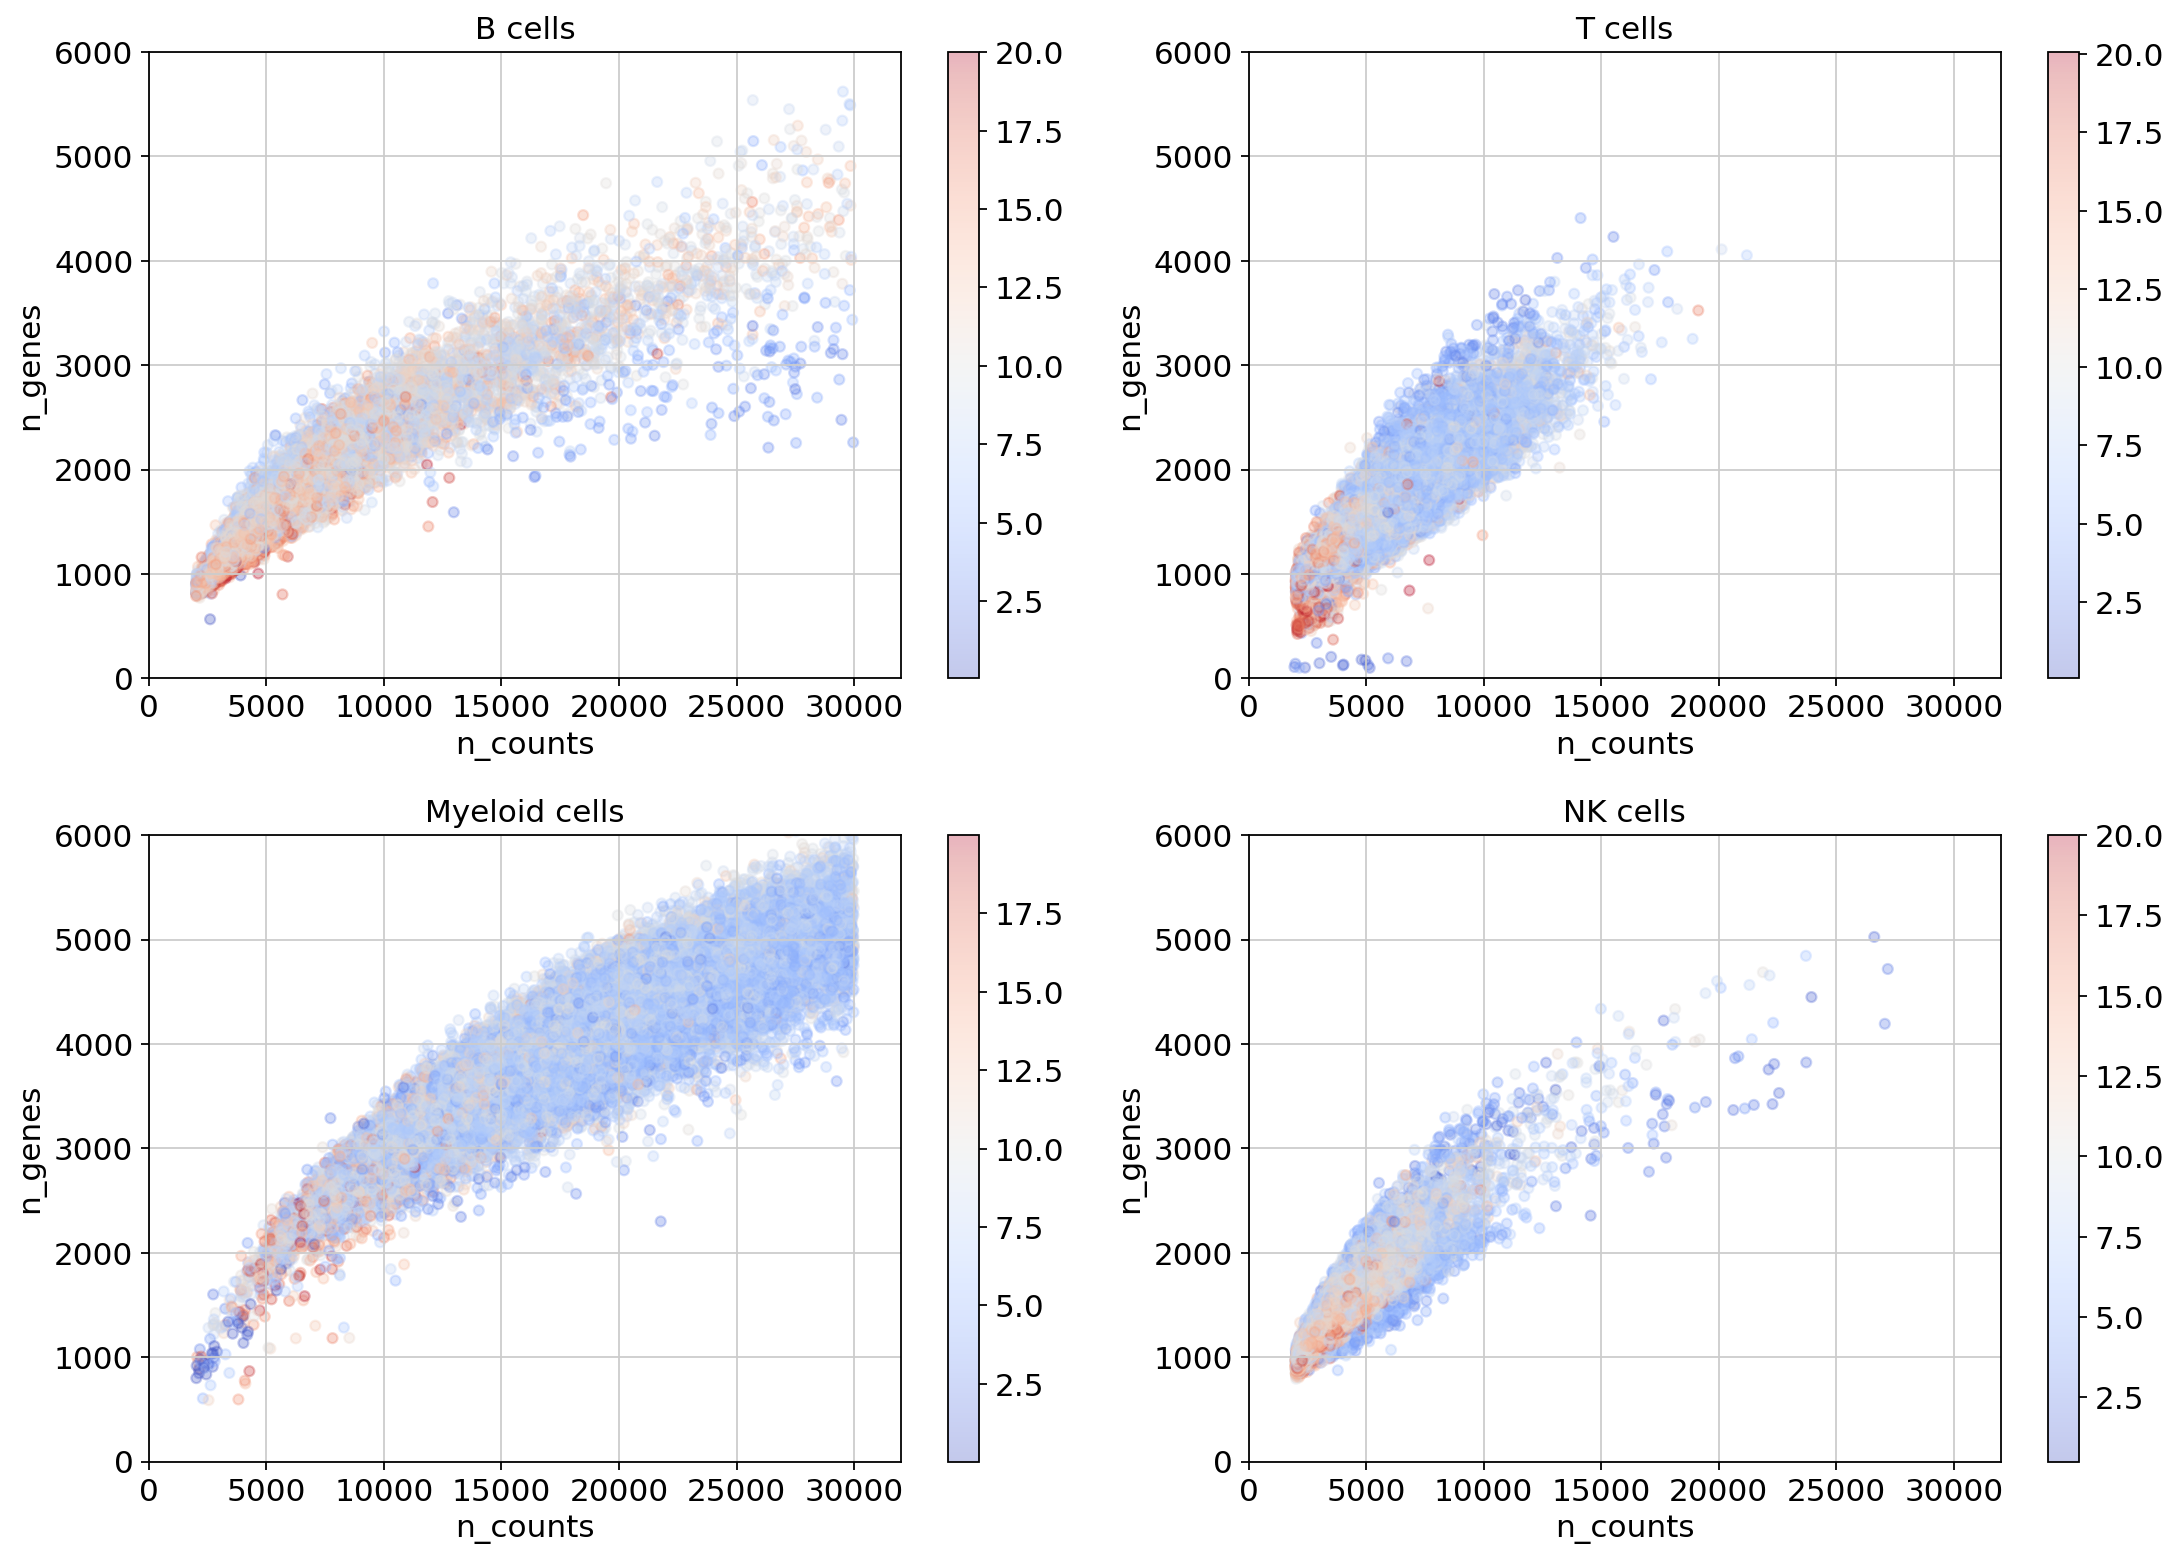

In [11]:
sc.set_figure_params(figsize=(4,4))
fig, axes = plt.subplots(2, 2, figsize=(14,10))
for i_celltype, cell_type in enumerate(sc_counts.obs.cell_type.unique()):
    ii = i_celltype // 2
    jj = i_celltype % 2
    ax = axes[ii][jj]
    
    mask = sc_counts.obs.cell_type == cell_type
    sc_counts_subset = sc_counts[mask,:]
    legend_loc = 'none'
    # if i_celltype==3:
    #     legend_loc = 'upper right'
    xx = sc_counts_subset.obs.n_counts
    yy = sc_counts_subset.obs.n_genes
    color = sc_counts_subset.obs.percent_mito
    
    scatter  = ax.scatter(xx, yy, c=color, s=20, alpha=.3, cmap='coolwarm')
    ax.set_xlabel('n_counts')
    ax.set_ylabel('n_genes')
    ax.set_xlim([0, 32000])
    ax.set_ylim([0, 6000])
    ax.set_title(cell_type)
    fig.colorbar(scatter, ax=ax)  # Add a color bar with label

plt.tight_layout()
plt.show()

In [12]:
sctk.cellwise_qc(sc_counts)

n_counts: [2451.0716313167804, 29992.009765625], 298152/301785 passed
n_genes: [1024.870089721006, 6238.99853515625], 297247/301785 passed
percent_mito: [0.025329280644655228, 18.950448181593497], 300892/301785 passed
percent_ribo: [7.117446014036448, 51.64668405810869], 296240/301785 passed
percent_hb: [0.0, 0.00920543506616024], 191652/301785 passed
183592/301785 pass


In [13]:
sctk.default_metric_params_df

,min,max,scale,side,min_pass_rate
n_counts,1000.00,NaN,log,min_only,0.10
n_genes,100.00,NaN,log,min_only,0.10
percent_mito,0.01,20.0,log,max_only,0.10
percent_ribo,0.00,100.0,log,both,0.10
percent_hb,NaN,1.0,log,max_only,0.10
percent_soup,NaN,5.0,log,max_only,0.10
percent_spliced,50.00,97.5,log,both,0.10
scrublet_score,NaN,0.3,linear,max_only,0.95


In [14]:
# for cells
print('n_counts:', sc_counts.obs.n_counts.min(), sc_counts.obs.n_counts.max())
print('n_genes:', sc_counts.obs.n_genes.min(), sc_counts.obs.n_genes.max())
print('percent_mito:', sc_counts.obs.percent_mito.min(), sc_counts.obs.percent_mito.max())
print('percent_ribo:', sc_counts.obs.percent_ribo.min(), sc_counts.obs.percent_ribo.max())
print('percent_hb:', sc_counts.obs.percent_hb.min(), sc_counts.obs.percent_hb.max())

n_counts: 1947.0 29992.0
n_genes: 101 6239
percent_mito: 0.025329280648429587 20.068317677198973
percent_ribo: 0.5988023952095809 63.80191274728154
percent_hb: 0.0 95.78558943484171


## Automatic filtering

In [15]:
if False:
    metrics_list = ["log1p_n_counts", "log1p_n_genes", "percent_mito", "percent_ribo", "percent_hb"]
    sctk.generate_qc_clusters(sc_counts, metrics = metrics_list)
    sc_counts

In [16]:
if False:
    sc.pl.embedding(sc_counts, "X_umap_qc", color=["qc_cluster", "log1p_n_counts"], color_map="OrRd")


In [17]:
if False:
    sctk.clusterwise_qc(sc_counts)
    sc_counts

In [18]:
#this won't be necessary in scanpy 1.10.0, booleans will become directly plottable
if False:
    for col in ['cell_passed_qc', 'cluster_passed_qc']:
        sc_counts.obs[col+"_int"] = sc_counts.obs[col].astype(int)
    sc.pl.embedding(sc_counts, "X_umap_qc", color=["cell_passed_qc_int", "cluster_passed_qc_int"])


the discrepency between cluster outlier and single cell outliers is extreme. we fall back to manual filtering.

## Manual filtering

### Cell wise

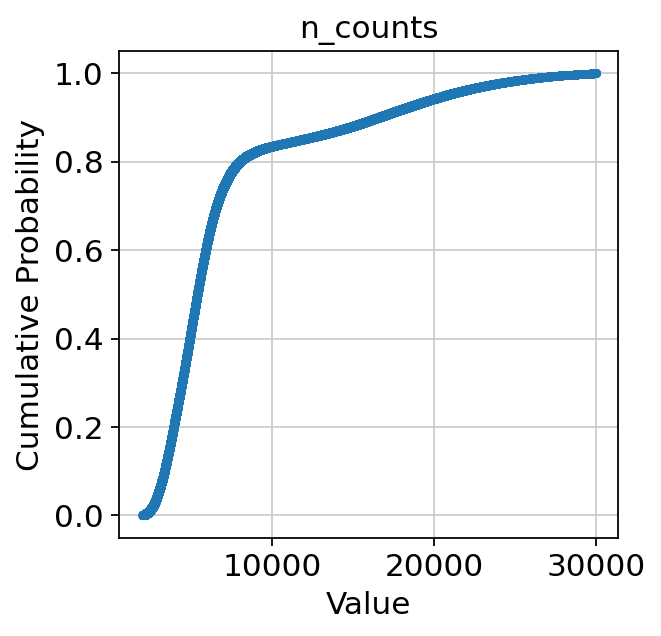

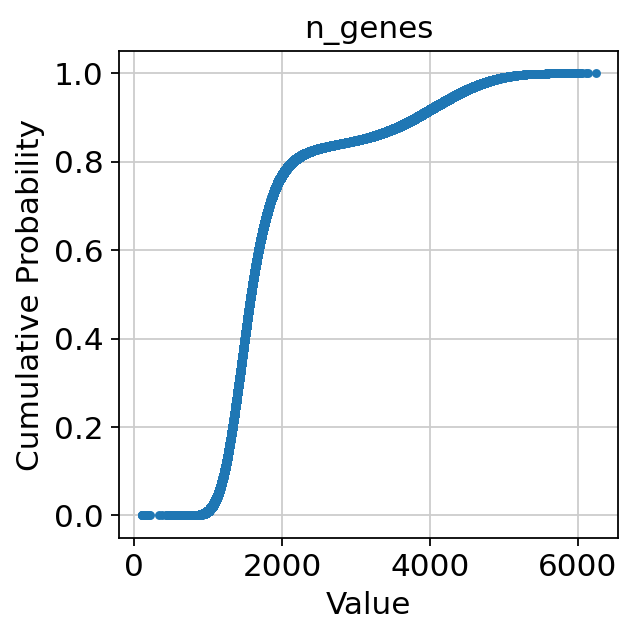

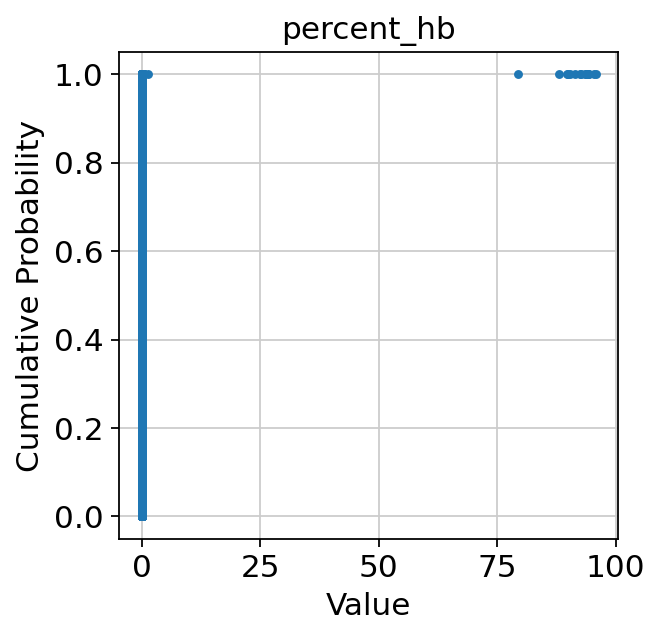

In [19]:
plot_CDF(sc_counts.obs.n_counts, 'n_counts')
plot_CDF(sc_counts.obs.n_genes, 'n_genes')
plot_CDF(sc_counts.obs.percent_hb, 'percent_hb')

In [20]:
# for cells
print('n_counts:', sc_counts.obs.n_counts.min(), sc_counts.obs.n_counts.max())
print('n_genes:', sc_counts.obs.n_genes.min(), sc_counts.obs.n_genes.max())
print('percent_mito:', sc_counts.obs.percent_mito.min(), sc_counts.obs.percent_mito.max())
print('percent_ribo:', sc_counts.obs.percent_ribo.min(), sc_counts.obs.percent_ribo.max())
print('percent_hb:', sc_counts.obs.percent_hb.min(), sc_counts.obs.percent_hb.max())

n_counts: 1947.0 29992.0
n_genes: 101 6239
percent_mito: 0.025329280648429587 20.068317677198973
percent_ribo: 0.5988023952095809 63.80191274728154
percent_hb: 0.0 95.78558943484171


In [21]:
filter_percent_hb = sc_counts.obs.percent_hb>.2
filter_percent_hb.sum()


20

In [22]:
sc_counts[filter_percent_hb,:].obs.plate_name.unique()


['010', '011', '012', '013']
Categories (4, object): ['010', '011', '012', '013']

In [23]:
filter_n_genes = sc_counts.obs.n_genes<1000
filter_n_genes.sum()

3234

In [24]:
sc_counts[filter_n_genes,:].obs.sm_name

index
AGTAACCGTCGCTTAA-1_SRTP0006403-0             Belinostat
ATCACAGTCGCGTGAC-1_SRTP0006403-0             Belinostat
TTACAGGGTATCGCAT-1_SRTP0006403-0             Belinostat
TTCTTGACAGCACGAA-3_SRTP0006405-0             Belinostat
GCTCAAAAGTTGAATG-5_SRTP0006407-0             Belinostat
                                            ...        
TCAGCAAGTGGTAATA-15_SRTP0006473-5    Mometasone Furoate
TGTGATGGTTGGTACT-15_SRTP0006473-5    Mometasone Furoate
TTCACGCGTCGTCATA-15_SRTP0006473-5    Mometasone Furoate
GGGTATTGTTGGTAGG-16_SRTP0006474-5          Clotrimazole
TCGAAGTCAGGCATGA-16_SRTP0006474-5          Clotrimazole
Name: sm_name, Length: 3234, dtype: category
Categories (147, object): ['5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin..., 'ABT737', 'ABT-199 (GDC-0199)', 'AMD-070 (hydrochloride)', ..., 'Vanoxerine', 'Vardenafil', 'Vorinostat', 'YK 4-279']

### Gene wise

In [25]:
# for genes
print('n_cells:', sc_counts.var.n_cells.min(), sc_counts.var.n_cells.max())

n_cells: 0 301783


In [26]:
p_threshold = 100
genes_tokeep_mask = np.ones(sc_counts.shape[1], dtype=bool)
for plate in sc_counts.obs['plate_name'].unique():
    mask = sc_counts.obs['plate_name'] == plate
    sc_counts_subset = sc_counts[mask,:]
    n_cells_by_count = (sc_counts_subset.X!=0).sum(axis=0)
    
    to_keep = np.ravel(n_cells_by_count>=p_threshold)

    print(genes_tokeep_mask.sum())
    genes_tokeep_mask = genes_tokeep_mask*to_keep
    

21265
16795
16618
16273
16222
15987


## Actual filtering

In [27]:
sc_counts = sc_counts[(~filter_n_genes) & (~filter_percent_hb), genes_tokeep_mask]


# Pseudobulking counts 

In [28]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
from scipy import sparse



In [29]:

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [30]:
# actuall bulking
bulk_adata = sum_by(sc_counts, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values
bulk_adata.X = np.array(bulk_adata.X.todense())

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

ratio of missingness 0.2247752673551846


In [31]:
bulk_adata.var.set_index('index', inplace=True)
bulk_adata.var.head()

,mito,ribo,hb,n_counts,n_cells
index,,,,,
A1BG,False,False,False,4088.0,4001
A1BG-AS1,False,False,False,10363.0,9896
A2M,False,False,False,47759.0,23246
A2M-AS1,False,False,False,28183.0,23010
A2MP1,False,False,False,1646.0,1613


In [32]:
bulk_adata.obs.cell_type.unique()

['B cells', 'Myeloid cells', 'NK cells', 'T cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells']

In [35]:
bulk_adata.write(f'{main_dir}/output/preprocess/bulk_adata.h5ad')